In [1]:
import vitaldb

import numpy as np
import scipy.signal as ss
from scipy.ndimage import minimum_filter1d, maximum_filter1d
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

# colorblind friendly palette
import matplotlib as mpl
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

plt.rcParams['figure.dpi'] = 72

df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information



In [2]:
track_names = ['ECG_II', 'ART', 'PLETH']
cids = vitaldb.find_cases(track_names)

print('searching for tracks:', track_names)
print('found', len(cids), 'cases')

vf = vitaldb.VitalFile(cids[0], track_names)

fs = 100
data = vf.to_numpy(track_names, 1/fs)
print(np.shape(data))


searching for tracks: ['ECG_II', 'ART', 'PLETH']
found 3458 cases
(1154110, 3)


In [3]:
vf = vitaldb.VitalFile(cids[0], track_names)

fs = 100
data = vf.to_numpy(track_names, 1/fs)
t = np.arange(data.shape[0]) / fs

ecg = data[:,0]
art = data[:,1]
ppg = data[:,2]


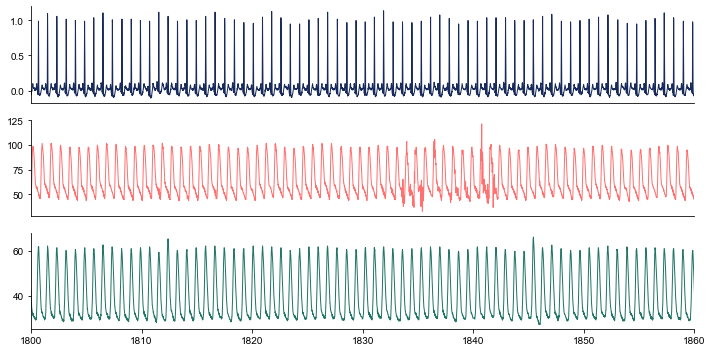

In [4]:
def um(ta=None, tb=None):
    ta = ta if ta else t.min()
    tb = tb if tb else t.max()
    twin = (t >= ta) & (t <= tb)

    plt.figure(figsize=(10,5))
    for i, sig in enumerate([ecg, art, ppg]):
        plt.subplot(3,1,i+1)
        plt.plot(t[twin], sig[twin], lw=1, c=cp[i])
        sns.despine(bottom=i<2)
        if i<2: plt.xticks([])
        plt.xlim(ta, tb)
    plt.tight_layout()
    plt.show()
    
# um()
um(60*30, 60*31)


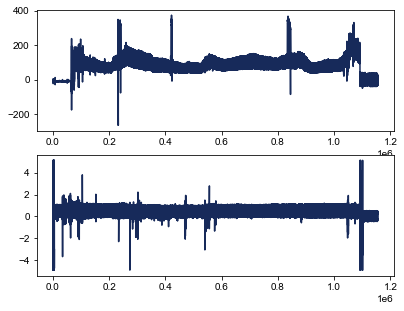

In [7]:
plt.subplot(2, 1, 1)
plt.plot(art)
plt.subplot(2, 1, 2)
plt.plot(ecg)

In [6]:
ymin = minimum_filter1d(art, int(fs*10))  # rolling minimum (windowed) --> diastolic
ymax = maximum_filter1d(art, int(fs*10))  # rolling maximum --> systolic

print(ymin)

# plt.xlim(4200, 4250)

artpeaks, _ = ss.find_peaks(art,
                            height=(ymax+ymin)/2,
                            prominence=(ymax-ymin)*0.3,
                            distance=fs/3)

#shouldn't have an unreasonable blood pressure
valid = (ymin > 20) & (ymax < 300)
print(valid)

#What are the valid peaks
yminp, ymaxp = ymin[artpeaks], ymax[artpeaks]  #systolic and diastolic pressures

#pressure shoudln't be changing a lot normally + normalize
ymindiff = np.abs(np.diff(yminp, prepend=yminp[0])) / (ymaxp - yminp)
ymaxdiff = np.abs(np.diff(ymaxp, prepend=ymaxp[0])) / (ymaxp - yminp)
valid[artpeaks[ymindiff > 0.3]] = False
valid[artpeaks[ymaxdiff > 0.3]] = False

#What's the ART Interval to get heartrate
rri = np.diff(artpeaks, prepend=0) / fs
hr = 60/rri
rriv = np.abs(np.diff(rri, append=0)) / rri

# Reasonable heartrate
valid[artpeaks[hr < 30]] = False
valid[artpeaks[rriv > 0.4]] = False


[ -9.79714  -9.79714  -9.79714 ... -35.471   -35.471   -35.471  ]
[False False False ... False False False]


In [7]:
ymin = minimum_filter1d(ppg, int(fs*10))
ymax = maximum_filter1d(ppg, int(fs*10))

ppgpeaks, _ = ss.find_peaks(ppg,
                            height=(ymax+ymin)/2,
                            prominence=(ymax-ymin)*0.3,
                            distance=fs/3)

yminp, ymaxp = ymin[ppgpeaks], ymax[ppgpeaks]
ymindiff = np.abs(np.diff(yminp, prepend=yminp[0])) / (ymaxp - yminp)
ymaxdiff = np.abs(np.diff(ymaxp, prepend=ymaxp[0])) / (ymaxp - yminp)
valid[ppgpeaks[ymindiff > 0.3]] = False
valid[ppgpeaks[ymaxdiff > 0.3]] = False

rri = np.diff(ppgpeaks, prepend=0) / fs
hr = 60/rri
rriv = np.abs(np.diff(rri, append=0)) / rri

valid[ppgpeaks[hr < 30]] = False
valid[ppgpeaks[rriv > 0.4]] = False



# Cound the sequential non NaN values
labels = np.cumsum(np.diff(valid, prepend=False))
counts = np.bincount(labels)[labels]
mask = valid & (counts > fs*61) #fs*61 is in the window length

#mask out everything that is both valid and wide enough. fs*61 


In [36]:
# plt.plot(t, ppg)
# plt.scatter(t[ppgpeaks], ppg[ppgpeaks], s=2, c=cp[4], zorder=2)
# plt.ylim(0, 100)
# plt.xlim(5000, 5050)

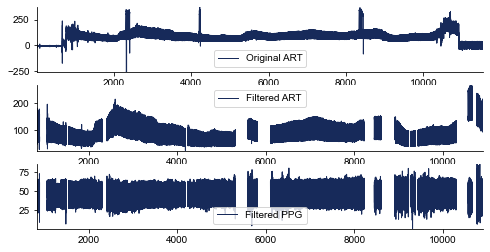

In [8]:
artm = art.copy()
artm[~mask] = np.nan

ppgm = ppg.copy()
ppgm[~mask] = np.nan

plt.figure(figsize=(8,4))
plt.subplot(3,1,1)
plt.plot(t, art, lw=1, label = "Original ART")
#plt.plot(t, artm, lw=1, label = "Filtered")
sns.despine()
plt.gca().margins(0)
plt.legend()

plt.subplot(3,1,2)
#plt.plot(t, art, lw=1, label = "Original")
plt.plot(t, artm, lw=1, label = "Filtered ART")
sns.despine()
plt.gca().margins(0)
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, ppgm, lw=1, label = "Filtered PPG")
#plt.plot(t, artm, lw=1, label = "Filtered")
sns.despine()
plt.gca().margins(0)
plt.legend()

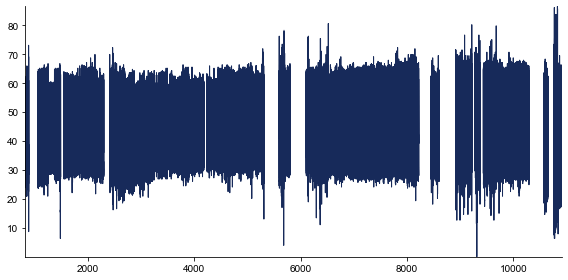

In [38]:
plt.figure(figsize=(8,4))
#plt.plot(t, ppg, lw=1, label="Original")
plt.plot(t, ppgm, lw=1, label="Filtered")
sns.despine()
plt.gca().margins(0)
plt.tight_layout()


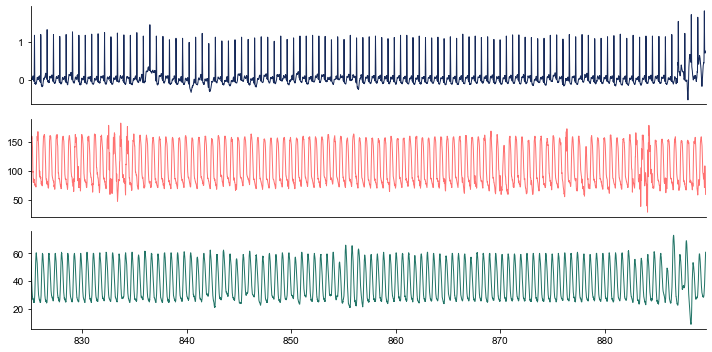

In [39]:
labels = np.cumsum(np.diff(mask, prepend=False))
# counts = np.bincount(labels)[labels]
# mask = valid & (counts > fs*60)
keepers = np.unique(labels[mask])
for l in keepers:
    ta, tb = t[labels == l][0], t[labels == l][-1]
    win = (t > ta) & (t < tb)
    
    um(ta, tb)
    
    break
    